EfficientNET

In [1]:
import torch
import torch.nn as nn
from math import ceil
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.optim as optim
import torch
import torch.nn.functional as F
import numpy as np
import PIL.Image as pim
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

Initialization

In [3]:
t = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize(mean=(0), std=(1))]
                       )

In [4]:
tempset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=t)

trainset, valset = torch.utils.data.random_split(tempset, [40000, 10000])

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=t)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512,
                                          shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(valset, batch_size=512,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=512,
                                         shuffle=False, num_workers=2)

Baseline model

In [6]:
base_model = [
    #expand_ratio, channels, repeats, stride, kernel_size, 
    [1, 16,  1, 1, 3],
    [6, 24,  2, 2, 3],
    [6, 40,  2, 2, 5],
    [6, 80,  3, 2, 3],
    [6, 112, 3, 1, 5],
    [6, 192, 4, 2, 5],
    [6, 320, 1, 1, 3]
]

phi_values

In [7]:
phi_values = {
    # phi_value, resolution, droprate
    "b0": (0,   224, 0.2),
    "b1": (0.5, 240, 0.2),
    "b2": (1,   260, 0.2),
    "b3": (2,   300, 0.2),
    "b4": (3,   380, 0.2),
    "b5": (4,   456, 0.2),
    "b6": (5,   528, 0.2),
    "b7": (6,   600, 0.2),
    
}

CNN Blocks

In [8]:
class CNNBlock(nn.Module):
    def __init__(
        self, in_channels,out_channels, kernel_size, stride, padding, groups=1
    ):
        super(CNNBlock, self).__init__()
        self.cnn = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            groups = groups,
            bias = False #becuase we are using batch norm - unnecessary parameter
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.silu = nn.SiLU() # SiLU <-> Swish
        
    def forward(self, x):
        return self.silu(self.bn(self.cnn(x)))

SqueezeExcitation

In [9]:
class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # C x H x W -> C x 1 x 1 X 1 X 1
            nn.Conv2d(in_channels, reduced_dim, 1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, in_channels, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        return x * self.se(x)

InvertedResidualBlock

In [10]:
class InvertedResidualBlock(nn.Module):
    def __init__(
            self,
        in_channels,
        out_channels,
        kernel_size,
        stride,
        padding,
        expand_ratio,
        reduction = 4, # queeze excitation
        survival_prob = 0.8, #for stochastic depth
    ):
        super(InvertedResidualBlock, self).__init__()
        self.survival_prob = 0.8
        self.use_residual = in_channels == out_channels and stride == 1
        #if we downsample we can not do skip connection becuase height and width won't match
        #if the in channels not equal to out channels can not be add either
        hidden_dim = in_channels * expand_ratio
        self.expand = in_channels != hidden_dim
        reduced_dim = int(in_channels / reduction)
        
        
        
        if self.expand:
            self.expand_conv = CNNBlock(
                in_channels, hidden_dim, kernel_size = 3, stride = 1, padding = 1,
            )
        self.conv = nn.Sequential(
            CNNBlock(
                hidden_dim, hidden_dim, kernel_size, stride, padding, groups = hidden_dim,
            ),
            SqueezeExcitation(hidden_dim, reduced_dim),
            #it does not change input and number of channels at all
            #it just get better weighting up with pritrtize
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )
    def stochastic_depth(self, x):#randomly removes a certain layer not in test time
        #in test time we do compute all of the layers
        if not self.training:
            return x
        
        binary_tensor = torch.rand(x.shape[0], 1, 1, 1, device = x.device) < self.survival_prob
        #compute value between 0 and 1 for each example
        return torch.div(x, self.survival_prob) * binary_tensor
    def forward(self, inputs):
        x = self.expand_conv(inputs) if self.expand else inputs
        
        if self.use_residual:
            return self.stochastic_depth(self.conv(x)) + inputs
        else: #if we dont use residual connection, if we downsampe or if the channel change
            return self.conv(x) # we are not using stochastic depth

In [11]:
class EfficientNet(nn.Module):
    def __init__(self, version, num_classes):
        super(EfficientNet, self).__init__()
        width_factor, depth_factor, dropout_rate = self.calculate_factors(version)
        last_channels = ceil(1280 * width_factor)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.featurs = self.create_features(width_factor, depth_factor, last_channels) #entier network
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(last_channels, num_classes),
        )
        
    def calculate_factors(self, version, alpha = 1.2, beta = 1.1 ): #alpha = depth-scaling = layers , beta = width-scaling = channels
        phi, res, drop_rate = phi_values[version]
        depth_factor = alpha ** phi
        width_factor = beta ** phi
        
        return width_factor, depth_factor, drop_rate

    def create_features(self, width_factor, depth_factor, last_channels):
        channels = int(32 * width_factor)
        features = [CNNBlock(3, channels, 3, stride=2, padding=1)]
        in_channels = channels
        
        for expand_ratio, channels, repeats, stride,  kernel_size in base_model:
            out_channels = 4*ceil(int(channels * width_factor) /4 )
            layers_repeats = ceil(repeats * depth_factor)
            #increasing width with out_channels
            for layer in range(layers_repeats):
                features.append(
                    InvertedResidualBlock(
                        in_channels,
                        out_channels,
                        expand_ratio = expand_ratio,
                        stride = stride if layer == 0 else 1,
                        kernel_size = kernel_size,
                        padding = kernel_size//2, #if k=1: p=0, if k=1: p=1, if k=1: p=2
                    )
                
                )
                in_channels = out_channels
        
        features.append(
            CNNBlock(in_channels, last_channels, kernel_size = 1, stride = 1, padding = 0)
        )
        return nn.Sequential(*features)
    
    def forward(self, x):

        x = self.pool(self.featurs(x))
        return self.classifier(x.view(x.shape[0], -1))

In [12]:
def test():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    version = "b0"
    phi, res, drop_rate = phi_values[version]
    num_example, num_classes = 4, 10
    x = torch.randn(num_example, 3, res,res).to(device)
    model = EfficientNet(
        version = version,
        num_classes = num_classes,
    
    ).to(device)
    
    print(model(x).shape)#(num_example, num_classes)
    print(model(x))
    
test()

torch.Size([4, 10])
tensor([[-0.3233, -0.1872,  0.2712,  0.0731, -0.4118,  0.1472,  0.0514,  0.1765,
          0.1373,  0.0780],
        [ 0.0199, -0.0579,  0.1115, -0.0219, -0.1370,  0.0771,  0.1745, -0.0340,
          0.2290,  0.1446],
        [-0.0840,  0.0164,  0.1767,  0.0717, -0.2049, -0.0121,  0.0941, -0.0856,
          0.0521,  0.0873],
        [-0.0062, -0.0682,  0.1969, -0.0369,  0.0477,  0.0430,  0.1408,  0.0630,
         -0.0201,  0.1869]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [13]:
def train(model, trainloader, optimizer, criterion ):
    
    loop = tqdm(trainloader, leave=True)

    running_loss = 0
    acc = []

    for idx, (img, label) in enumerate(loop):
        img = img.to(DEVICE)
        label = label.to(DEVICE)

        model.train()

        # Zero the gradients.
        optimizer.zero_grad()
        output = model(img)
        
        a = torch.max(output , 1)
        acc.append(sum(a[1] == label.to(DEVICE) )/len(label))

        loss = criterion(output, label)

        #Backwrd pss.
        loss.backward()

        running_loss += loss.item()

        # Update the parameters in the optimizer.

        optimizer.step()
        running_loss += loss.item()
    return model, (running_loss/len(trainloader) ) , optimizer, (sum(acc)/len(acc))



In [83]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    acc = []
    
    with torch.no_grad():
    
        for i, (img,label) in enumerate(iterator):
            
            img = img.to(DEVICE)
            label = label.to(DEVICE)
            
            output = model(img)

            a = torch.max(output , 1)
            acc.append(sum(a[1] == label.to(DEVICE) )/len(label))

            
            loss = criterion(output, label) 

            epoch_loss += loss.item()
        
    return (epoch_loss / len(iterator)), (sum(acc)/len(acc))

In [106]:
version = "b0"
learning_rate = 0.003
phi, res, drop_rate = phi_values[version]
num_example, num_classes = 4, 10
model = EfficientNet( version = version, num_classes = num_classes, ).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=learning_rate , weight_decay = 1e-5)
criterion = nn.CrossEntropyLoss()

In [107]:
loss_data_train      =  []
loss_data_val        =  []
acc_data_train = []
acc_data_val   = []

#model = EfficientNet( version = version, num_classes = num_classes, ).to(DEVICE)


for epoch in range(0 , 15):
    model, loss_train_temp, optimizer, acc_train = train(model, trainloader , optimizer, criterion)
    loss_val_temp, acc_val  = evaluate(model, valloader, criterion )
    print("epoch" ,epoch+1 , "-->" , "loss train:" ,loss_train_temp ," | loss vaidation: ", loss_val_temp)
    
    loss_data_train.append(loss_train_temp)
    loss_data_val.append(loss_val_temp)
    
    acc_data_train.append(acc_train.cpu())
    acc_data_val.append(acc_val.cpu())


100%|██████████| 79/79 [00:07<00:00, 10.05it/s]


epoch 1 --> loss train: 4.001981412308125  | loss vaidation:  2.0288699567317963


100%|██████████| 79/79 [00:07<00:00, 10.55it/s]


epoch 2 --> loss train: 3.456110685686522  | loss vaidation:  1.6561106860637664


100%|██████████| 79/79 [00:07<00:00, 10.49it/s]


epoch 3 --> loss train: 3.180423075639749  | loss vaidation:  1.860897272825241


100%|██████████| 79/79 [00:07<00:00, 10.58it/s]


epoch 4 --> loss train: 3.0953828202018254  | loss vaidation:  1.4355689108371734


100%|██████████| 79/79 [00:07<00:00, 10.48it/s]


epoch 5 --> loss train: 2.7901543846613244  | loss vaidation:  1.4723888099193574


100%|██████████| 79/79 [00:07<00:00,  9.92it/s]


epoch 6 --> loss train: 2.6063372153270095  | loss vaidation:  1.2668999016284943


100%|██████████| 79/79 [00:08<00:00,  9.54it/s]


epoch 7 --> loss train: 2.2055418234837205  | loss vaidation:  1.0607922792434692


100%|██████████| 79/79 [00:07<00:00, 10.44it/s]


epoch 8 --> loss train: 1.9950660180441941  | loss vaidation:  1.1784768760204316


100%|██████████| 79/79 [00:07<00:00, 10.41it/s]


epoch 9 --> loss train: 2.483677526063557  | loss vaidation:  1.1347567319869996


100%|██████████| 79/79 [00:07<00:00, 10.37it/s]


epoch 10 --> loss train: 2.092384445516369  | loss vaidation:  1.0556874334812165


100%|██████████| 79/79 [00:07<00:00, 10.16it/s]


epoch 11 --> loss train: 1.8151136923439894  | loss vaidation:  0.9762809157371521


100%|██████████| 79/79 [00:08<00:00,  9.58it/s]


epoch 12 --> loss train: 1.6234206247933303  | loss vaidation:  0.9386108964681625


100%|██████████| 79/79 [00:07<00:00, 10.31it/s]


epoch 13 --> loss train: 1.4600960212417795  | loss vaidation:  0.902402377128601


100%|██████████| 79/79 [00:07<00:00, 10.38it/s]


epoch 14 --> loss train: 1.3122678557528724  | loss vaidation:  0.8926307469606399


100%|██████████| 79/79 [00:07<00:00, 10.32it/s]


epoch 15 --> loss train: 1.1997539468958407  | loss vaidation:  0.9097929835319519


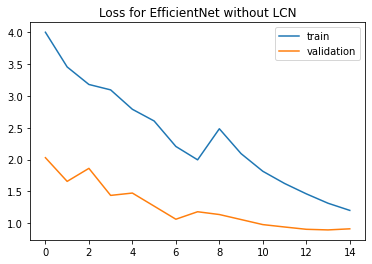

In [146]:
plt.plot(loss_data_train)
plt.plot(loss_data_val)
plt.legend(['train', 'validation'])
plt.title("Loss for EfficientNet without LCN");

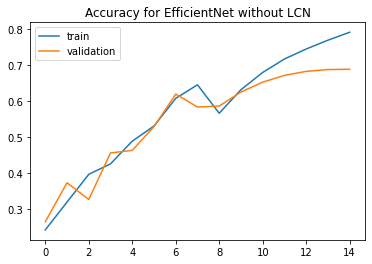

In [145]:
plt.plot(acc_data_train)
plt.plot(acc_data_val)
plt.legend(['train', 'validation'])
plt.title("Accuracy for EfficientNet without LCN");

In [147]:
acc = []
for iter,(img,label) in enumerate(testloader):
    out = model(img.to(DEVICE))
    a = torch.max(out , 1)
    acc.append(sum(a[1] == label.to(DEVICE) )/len(label))
print("test set accuracy:", sum(acc)/len(acc))

test set accuracy: tensor(0.6964, device='cuda:0')


adding layer

In [111]:
def gauss_dist(x, y, sigma = 2.0):
    z = 2 * np.pi * sigma ** 2
    return  1.0 / z *np.exp(-(x ** 2 + y ** 2) / (2. * sigma ** 2))

In [112]:
def gaussian_filter(kernel_shape):
    filter = np.zeros(kernel_shape, dtype='float32')
    
    mid = np.floor(kernel_shape[-1] / 2.0)
    for idx in range(0, kernel_shape[1]):
        for i in range(0, kernel_shape[2]):
            for j in range(0, kernel_shape[3]):
                filter[0, idx, i, j] = gauss_dist(i - mid , j - mid )# i = (-4, 4) j = (-4, 4)
    return filter / np.sum(filter)

In [113]:
kernel_shape = (1, 3, 9, 9)
a = gaussian_filter(kernel_shape)

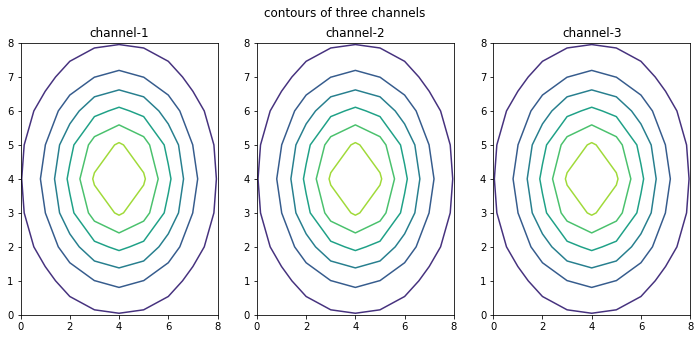

In [114]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize =(12,5))
fig.suptitle('contours of three channels')
ax1.contour(a[0][0])
ax1.set_title("channel-1")
ax2.contour(a[0][1])
ax2.set_title("channel-2")
ax3.contour(a[0][2])
ax3.set_title("channel-3");

In [115]:
def  LCN(idx, data):
    if data == "train":
        dataset = trainset
    elif data == "val":
        dataset = valset
    elif data == "test":
        dataset = testset
        
    gauss_filter = torch.Tensor(gaussian_filter((1, 3 ,9 ,9)))
    
    #convolving
    img_filtered = F.conv2d(dataset[idx][0].unsqueeze(0), gauss_filter, padding = 8)
    mid = int(np.floor(gauss_filter.shape[2] / 2.))
    
    #Centerd Image
    #The centered image should have a mean close to 0
    #subtractive Normalization
    centered_img = (dataset[idx][0] - img_filtered[:,:,mid:-mid,mid:-mid][0][0])
    
    #variance
    centered_img_pow = F.conv2d(centered_img.pow(2).unsqueeze(0), gauss_filter, padding = 8)
    centered_img_sqrt = centered_img_pow[:,:,mid:-mid,mid:-mid].sqrt()
    img_mean = centered_img_sqrt.mean()
    
    ## Divisive Normalization
    div = np.maximum(img_mean.numpy(),centered_img_sqrt.numpy())
    div = np.maximum(div, 1e-4)
    new_image = centered_img / torch.Tensor(div)
    return new_image

In [116]:
def create_new_dataset(data):
    
    if data == "train":
        dataset = trainset
    elif data == "val":
        dataset = valset
    elif data == "test":
        dataset = testset
    
    list_img = []
    labels = []
        
    for idx, (img,label) in enumerate(dataset):
        new_img = LCN(idx, data)
        list_img.append(new_img.squeeze(0))
        labels.append(label)
    new_dataset = list(zip(list_img, labels))
    return new_dataset


In [117]:
lcn_trainset = create_new_dataset("train")
lcn_valset   = create_new_dataset("val")
lcn_testset  = create_new_dataset("test")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'image without LCN Layer')

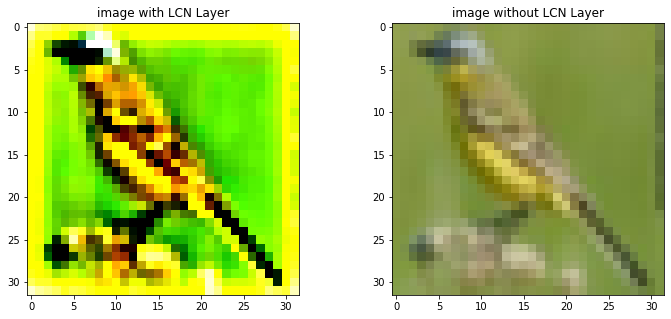

In [118]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(12,5))
ax1.imshow(lcn_trainset[20][0].permute(1,2,0))
ax2.imshow(trainset[20][0].permute(1,2,0));
ax1.set_title("image with LCN Layer")
ax2.set_title("image without LCN Layer")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'image without LCN Layer')

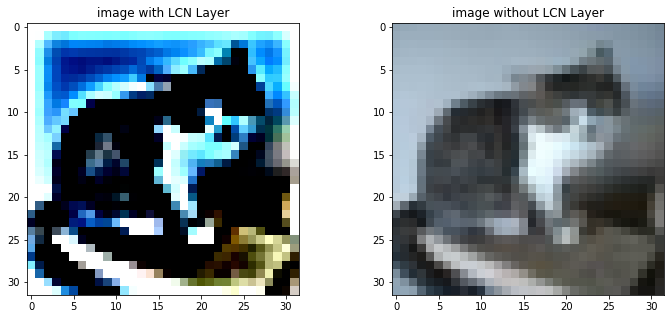

In [119]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(12,5))
ax1.imshow(lcn_valset[20][0].permute(1,2,0))
ax2.imshow(valset[20][0].permute(1,2,0));
ax1.set_title("image with LCN Layer")
ax2.set_title("image without LCN Layer")

In [120]:
lcn_trainloader = torch.utils.data.DataLoader(lcn_trainset, batch_size=512,
                                          shuffle=True, num_workers=2)

lcn_valloader = torch.utils.data.DataLoader(lcn_valset, batch_size=512,
                                          shuffle=True, num_workers=2)

lcn_testloader = torch.utils.data.DataLoader(lcn_testset, batch_size=512,
                                         shuffle=False, num_workers=2)

In [134]:
version = "b0"
learning_rate = 0.003
phi, res, drop_rate = phi_values[version]
num_example, num_classes = 4, 10
model_lcn = EfficientNet( version = version, num_classes = num_classes, ).to(DEVICE)
optimizer_lcn = optim.Adam(model_lcn.parameters(), lr=learning_rate , weight_decay = 1e-5)
criterion_lcn = nn.CrossEntropyLoss()

In [135]:
loss_data_train_lcn      =  []
loss_data_val_lcn        =  []
acc_data_train_lcn = []
acc_data_val_lcn   = []

#model = EfficientNet( version = version, num_classes = num_classes, ).to(DEVICE)

for epoch in range(0 , 15):
    model_lcn, loss_train_temp, optimizer_lcn, acc_train = train(model_lcn, lcn_trainloader , optimizer_lcn, criterion_lcn)
    loss_val_temp, acc_val  = evaluate(model_lcn, lcn_valloader, criterion_lcn )
    print("epoch" ,epoch+1 , "-->" , "loss train:" ,loss_train_temp ," | loss vaidation: ", loss_val_temp)
    
    loss_data_train_lcn.append(loss_train_temp)
    loss_data_val_lcn.append(loss_val_temp)
    
    acc_data_train_lcn.append(acc_train.cpu())
    acc_data_val_lcn.append(acc_val.cpu())

100%|██████████| 79/79 [00:07<00:00, 10.86it/s]


epoch 1 --> loss train: 4.011259423026556  | loss vaidation:  2.585060101747513


100%|██████████| 79/79 [00:07<00:00,  9.96it/s]


epoch 2 --> loss train: 3.3249240676058998  | loss vaidation:  1.5263342678546905


100%|██████████| 79/79 [00:07<00:00, 10.23it/s]


epoch 3 --> loss train: 2.880951534343671  | loss vaidation:  1.522900640964508


100%|██████████| 79/79 [00:07<00:00, 10.52it/s]


epoch 4 --> loss train: 2.5591991068441655  | loss vaidation:  1.2337586522102355


100%|██████████| 79/79 [00:08<00:00,  9.65it/s]


epoch 5 --> loss train: 2.2632765422893475  | loss vaidation:  1.1853703916072846


100%|██████████| 79/79 [00:07<00:00, 10.75it/s]


epoch 6 --> loss train: 2.5377883186823205  | loss vaidation:  1.3808174550533294


100%|██████████| 79/79 [00:07<00:00, 10.55it/s]


epoch 7 --> loss train: 2.5206359006181547  | loss vaidation:  1.5708714962005614


100%|██████████| 79/79 [00:07<00:00, 10.74it/s]


epoch 8 --> loss train: 2.232587669469133  | loss vaidation:  1.0014651358127593


100%|██████████| 79/79 [00:07<00:00, 10.46it/s]


epoch 9 --> loss train: 1.8548908656156515  | loss vaidation:  0.9329605162143707


100%|██████████| 79/79 [00:07<00:00, 10.35it/s]


epoch 10 --> loss train: 1.6590005114108701  | loss vaidation:  0.8980539828538895


100%|██████████| 79/79 [00:07<00:00, 10.74it/s]


epoch 11 --> loss train: 1.5125156490108635  | loss vaidation:  0.8809832870960236


100%|██████████| 79/79 [00:08<00:00,  9.80it/s]


epoch 12 --> loss train: 1.371876796589622  | loss vaidation:  0.881811648607254


100%|██████████| 79/79 [00:07<00:00, 10.70it/s]


epoch 13 --> loss train: 1.2519802096523815  | loss vaidation:  0.8654855012893676


100%|██████████| 79/79 [00:07<00:00, 10.73it/s]


epoch 14 --> loss train: 1.1868097880218602  | loss vaidation:  0.8861529618501663


100%|██████████| 79/79 [00:07<00:00, 10.71it/s]


epoch 15 --> loss train: 1.0342170090614995  | loss vaidation:  0.8898759126663208


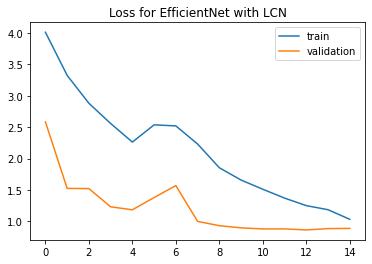

In [148]:
plt.plot(loss_data_train_lcn)
plt.plot(loss_data_val_lcn)
plt.legend(['train', 'validation'])
plt.title("Loss for EfficientNet with LCN");

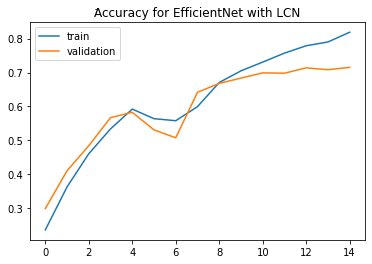

In [149]:
plt.plot(acc_data_train_lcn)
plt.plot(acc_data_val_lcn)
plt.legend(['train', 'validation'])
plt.title("َAccuracy for EfficientNet with LCN");

In [138]:
acc = []
for iter,(img,label) in enumerate(lcn_testloader):
    out = model_lcn(img.to(DEVICE))
    a = torch.max(out , 1)
    acc.append(sum(a[1] == label.to(DEVICE) )/len(label))
print("test set accuracy:", sum(acc)/len(acc))

test set accuracy: tensor(0.7110, device='cuda:0')


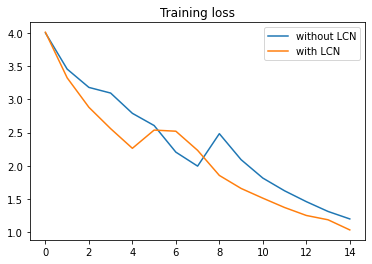

In [151]:
plt.plot(loss_data_train)
plt.plot(loss_data_train_lcn)
plt.legend(['without LCN', 'with LCN'])
plt.title("Training loss");

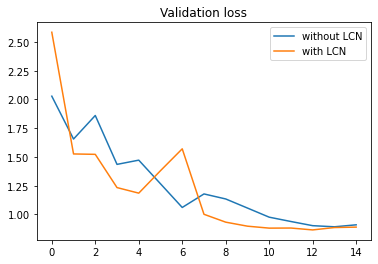

In [152]:
plt.plot(loss_data_val)
plt.plot(loss_data_val_lcn)
plt.legend(['without LCN', 'with LCN'])
plt.title("Validation loss");

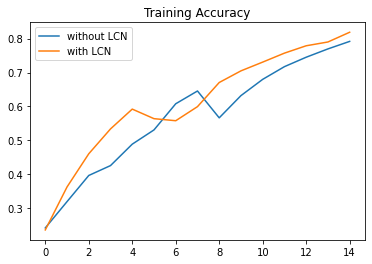

In [153]:
plt.plot(acc_data_train)
plt.plot(acc_data_train_lcn)
plt.legend(['without LCN', 'with LCN'])
plt.title("Training Accuracy");

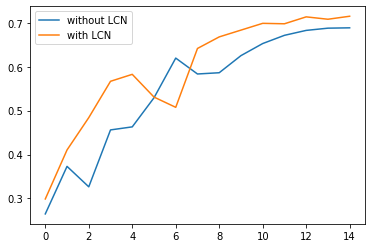

In [142]:
plt.plot(acc_data_val)
plt.plot(acc_data_val_lcn)
plt.legend(['without LCN', 'with LCN'])
plt.title("Validation accuracy");